**Dependencies**

In [20]:
from DataDownload import *
from PreProcessing import *
from EventIdentification import *
from CataloguedEvents import *
from PostProcessing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch


**Initiating Parameters For The Day**

In [2]:
# Set date and station for studying423
date = UTCDateTime("2024-04-23") 
station = ['AM','R50D6','https://data.raspberryshake.org']

# Set global earthquake catalogue provider
providers = ["IRIS", "USGS", "EMSC"]

**Download And Read Stream**

Data for 2024-04-23 already exist.
Stream loaded from file.
----------------------------------------
1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-22T23:00:00.004000Z - 2024-04-24T01:00:00.004000Z | 100.0 Hz, 9360001 samples


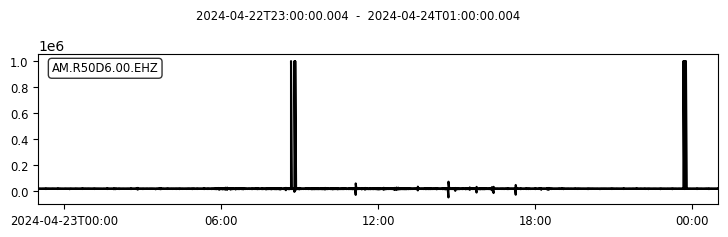

In [3]:
original_stream = download_stream(date, station, overwrite=False)
print(original_stream)

original_stream.plot();

Processed Stream ( Demean, Detrend, Outlier Removal And Band Pass Filtering )

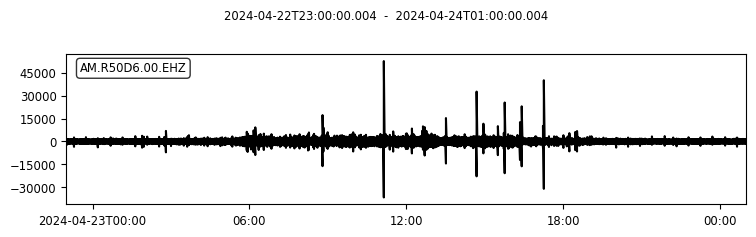

In [4]:
processed_stream = stream_process(original_stream)
processed_stream.plot();

Denoise Using Pretrained DeepDenoiser Model

CUDA available. Running on GPU


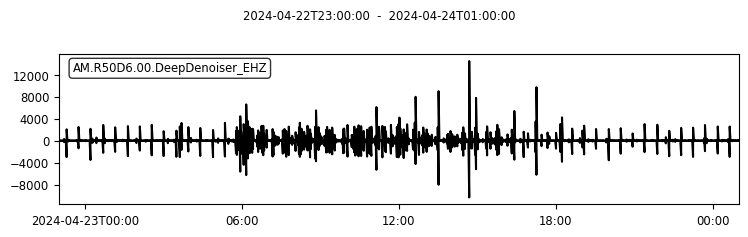

In [5]:
# Get pretrained model for denosing
denoiser_model = sbm.DeepDenoiser.from_pretrained("original")

# Denoising the stream 
denoised_stream = deep_denoiser(processed_stream, denoiser_model)

# Showing denoised stream
denoised_stream.plot();

**Performance Testing**

In [6]:
#model_GPD = sbm.GPD.from_pretrained("stead")
#GPD_times = test_model_performance(processed_stream, model_GPD)

In [7]:
#model_PhaseNet = sbm.PhaseNet.from_pretrained("stead")
#PhaseNet_times = test_model_performance(processed_stream, model_PhaseNet)

In [8]:
#model_EQTransformer = sbm.EQTransformer.from_pretrained("original")
#EQTransformer_times = test_model_performance(processed_stream, model_EQTransformer)

Pre-trained Deep Learning Model

In [10]:
# Get pretrained model for phase picking
phase_picking_model = sbm.EQTransformer.from_pretrained("original")

# Threshold to filter out false positives
confidence_threshold = 0.7

# Detect P and S waves from stream
df_detected = pretrained_phase_picking(denoised_stream, phase_picking_model)

# Filter by confidence threshold
df_detected = df_detected[df_detected['peak_confidence'] >= confidence_threshold]

# Show results
df_detected

CUDA available. Running on GPU


,peak_time,peak_confidence,phase
6,2024-04-22T23:12:40.960000Z,0.872073,P
8,2024-04-22T23:18:19.110000Z,0.700669,P
13,2024-04-22T23:21:43.220000Z,0.739402,S
15,2024-04-22T23:32:53.070000Z,0.724996,P
33,2024-04-23T00:16:35.020000Z,0.798008,P
...,...,...,...
1374,2024-04-23T22:46:44.760000Z,0.826177,P
1377,2024-04-23T23:14:25.280000Z,0.830160,P
1389,2024-04-23T23:42:06.020000Z,0.895768,P
1413,2024-04-24T00:33:58.880000Z,0.749654,S


**Find Earthquake From Catalogue**

In [11]:
catalogue_path = request_catalogue(
    catalogue_providers= providers,
    coordinates = get_coordinates(station) ,
    date = date,
    radmin=0,
    radmax=90,
    minmag=5,
    maxmag=10,
    overwrite = True
)

catalogue = load_earthquake_catalog(catalogue_path)
print_catalogued(catalogue)

Catalog saved to D:\Dissertation\data\catalogue\2024-04-23_IRIS.xml
Loading catalogue from path.
----------------------------------------
5 Event(s) in Catalog:
2024-04-23T15:40:05.079000Z | +38.158,  -30.835 | 5.2  Mww
2024-04-23T13:05:39.336000Z | +50.100,  -28.970 | 5.0  mww
2024-04-23T02:20:59.691000Z | +23.826, +121.633 | 5.2  Mwr
2024-04-23T00:11:02.661000Z | +23.898, +121.598 | 5.2  mb
2024-04-23T00:04:05.608000Z | +23.803, +121.676 | 5.8  mww



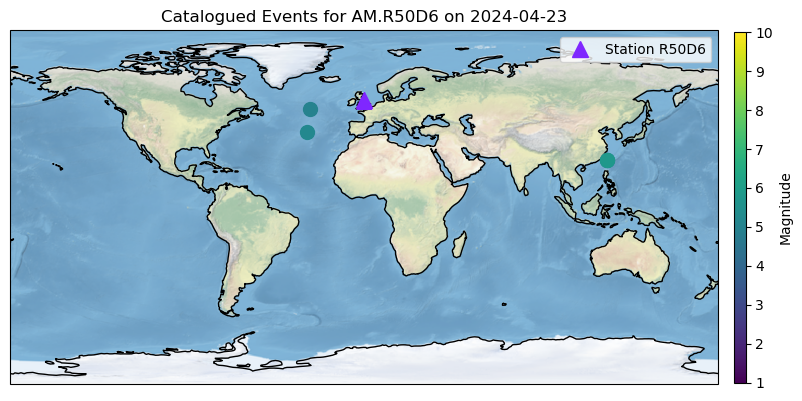

In [12]:
plot_catalogue(catalogue, station, date, fill_map=True)

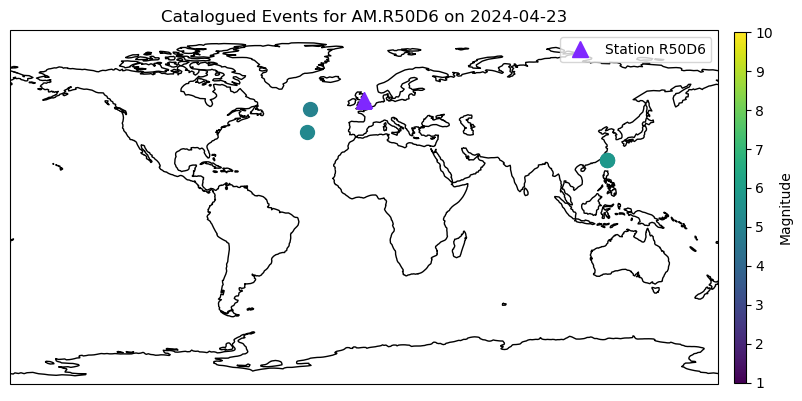

In [13]:
plot_catalogue(catalogue, station, date, fill_map=False)

**Create a DataFrame for Catalogued Events with Predicted Arrival Times**

In [14]:
df_catalogued = process_catalogue(catalogue, get_coordinates(station))
df_catalogued

,event_id,time,lat,long,mag,mag_type,depth,epi_distance,P_predict,S_predict,catalogued,detected,P_detected,S_detected
0,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,18011.0,2872.781306,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None
1,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,9121.0,1921.274830,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,False,None,None
2,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T02:20:59.691000,23.8259,121.6333,5.2,Mwr,10000.0,9764.020713,2024-04-23T02:33:49.058574,2024-04-23T02:44:32.124338,True,False,None,None
3,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,13296.0,9755.277743,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,False,None,None
4,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,13118.0,9768.402629,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None


**Compare DataFrames And Merge Events Detected In Catalogue**

In [15]:
result_df = match_and_merge(df_catalogued, df_detected, time_tolerance = 10)
print_matching_result(result_df)

Detected in Catalogue: 2
Not Detected in Catalogue: 3
Detected but Not in Catalogue: 193



**DataFrame Containing All Events For The Day Categorized**

In [16]:
result_df

,event_id,time,lat,long,mag,mag_type,depth,epi_distance,P_predict,S_predict,catalogued,detected,P_detected,S_detected,P_peak_confidence,peak_confidence
0,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,18011.0,2872.781306,2024-04-23T15:45:38.589923,2024-04-23T15:50:13.947963,True,False,None,None,NaN,NaN
1,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,9121.0,1921.274830,2024-04-23T13:09:42.848903,2024-04-23T13:13:21.000711,True,True,2024-04-23T13:09:48.950000,None,0.703402,NaN
2,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T02:20:59.691000,23.8259,121.6333,5.2,Mwr,10000.0,9764.020713,2024-04-23T02:33:49.058574,2024-04-23T02:44:32.124338,True,True,2024-04-23T02:33:40.040000,None,0.859432,NaN
3,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,13296.0,9755.277743,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,False,None,None,NaN,NaN
4,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,13118.0,9768.402629,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T22:46:44.760000,None,NaN,0.826177
194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T23:14:25.280000,None,NaN,0.830160
195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T23:42:06.020000,None,NaN,0.895768
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,None,2024-04-24T00:33:58.880000,NaN,0.749654


**Visualize Phase Predictions For Successfully Matched Events**

CUDA available. Running on GPU


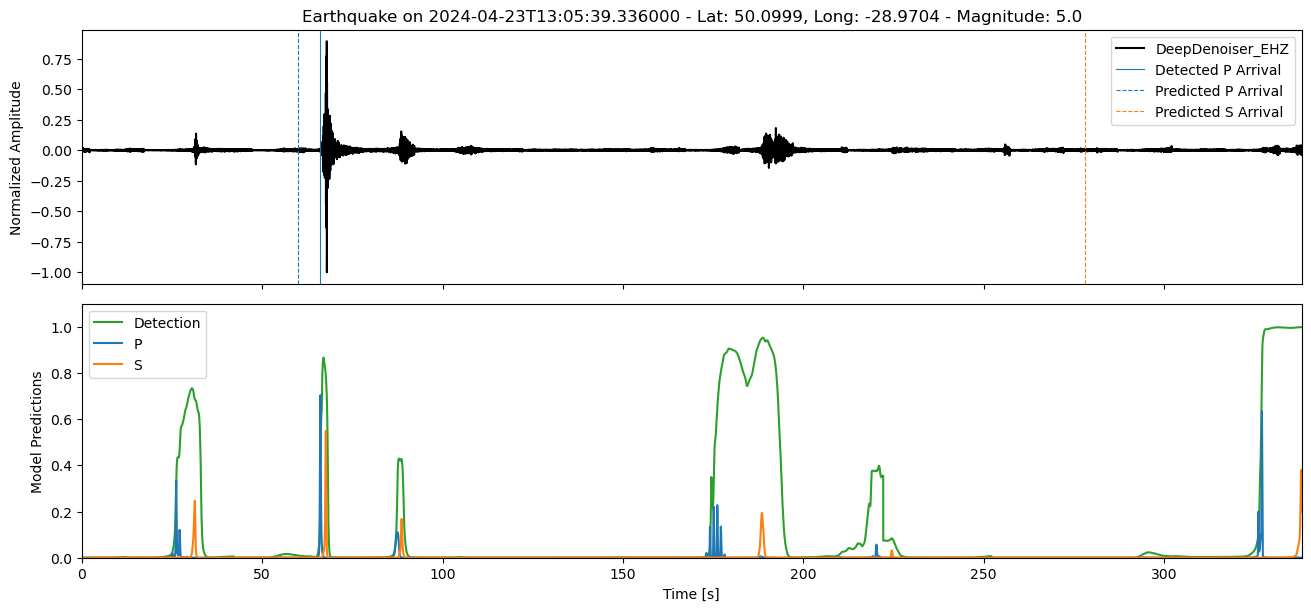

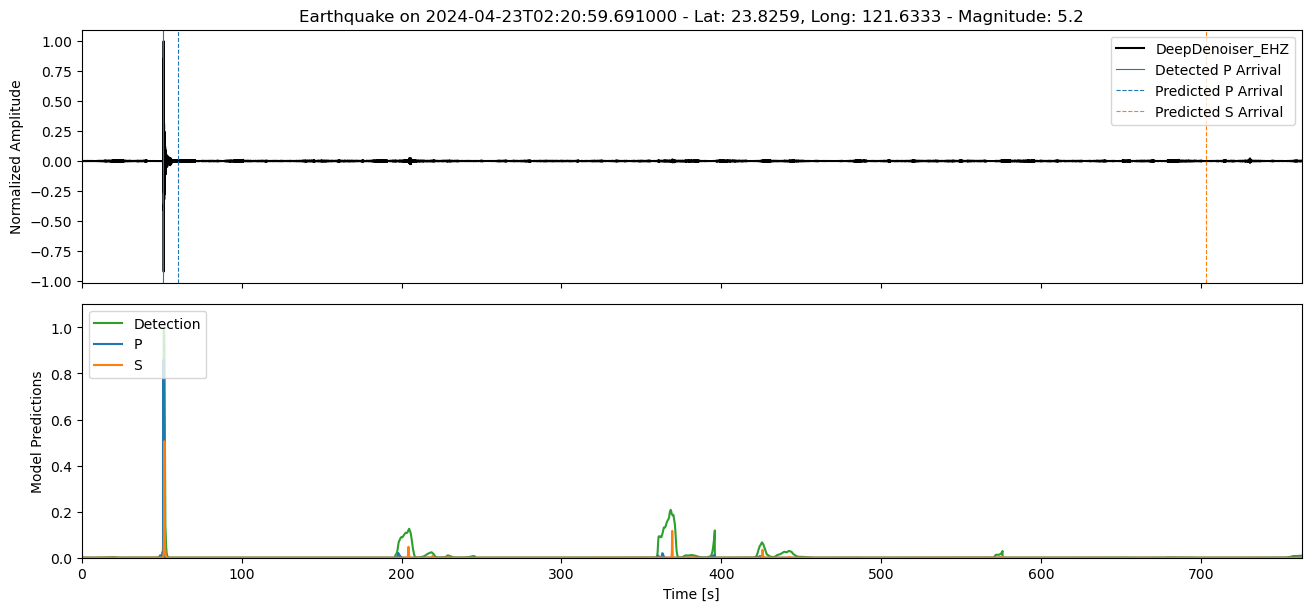

In [17]:
matched_events = result_df[(result_df['catalogued'] == True) & (result_df['detected'] == True)]
predictions = make_prediction(denoised_stream, phase_picking_model)

for _, row in matched_events.iterrows():
    earthquake_info = get_event_info(row)  
    
    if matched_events.empty:
        continue
    plot_predictions_wave(denoised_stream,predictions, row['P_detected'], row['S_detected'], row['P_predict'], row['S_predict'], earthquake_info)

**Information For Successfully Detected Events From Catalogue**

In [18]:
for _, row in matched_events.iterrows():
    earthquake_info = get_event_info(row)  
    
    if matched_events.empty:
        continue
    print_event_statistics(earthquake_info)

Earthquake Time: 2024-04-23T13:05:39.336000
Location: Lat 50.0999, Long -28.9704
Magnitude: 5.0 mww
Depth: 9121.0 m
Distance to Station: 1921.27 km
P wave Confidence: 0.7034019827842712
S wave Confidence: None
----------------------------------------
Earthquake Time: 2024-04-23T02:20:59.691000
Location: Lat 23.8259, Long 121.6333
Magnitude: 5.2 Mwr
Depth: 10000.0 m
Distance to Station: 9764.02 km
P wave Confidence: 0.8594319820404053
S wave Confidence: None
----------------------------------------
